In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import pandas as pd
from bokeh.plotting import figure, output_file, output_notebook, show, save
from bokeh.models import CustomJS, ColumnDataSource, BoxSelectTool, Rect, HoverTool, BoxZoomTool, WheelZoomTool, LassoSelectTool, PanTool, Div
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import column, row
import umap


Using Theano backend.


In [2]:
dataset = '../../data/digits.npz'
data = np.load(dataset)
X = data['X']
y = data['y'] if 'y' in data else None
X = X.astype(np.float32)
X /= 255.
nb_classes = 10

In [12]:
#clf = load('../../discr/digits_and_letters')
#clf_enc = Model(inputs=clf.layers[0].input, outputs=clf.get_layer('p_re_lu_4').output)
#clf_enc = Model(inputs=clf.layers[0].input, outputs=clf.layers[0].output)
model = load('../results/mnist')
clf_enc= Model(inputs=model.layers[0].input, outputs=model.get_layer('activation_3').output)

In [19]:
folders = ['mnist', 'mnist5']
nb_gen = 10000
Xfull = []
yfull = []
hfull = []
nb_gen_total = 0
for i,f in enumerate(folders):
    gen = np.load('../results/{}/gen/generated.npz'.format(f))
    Xgen = gen['generated'][0:nb_gen]
    ygen = np.array([i + nb_classes] * len(Xgen))
    hgen = clf_enc.predict(Xgen)    
    hgen = hgen.reshape((hgen.shape[0], -1))
    Xfull.append(Xgen)
    yfull.append(ygen)
    hfull.append(hgen)
    nb_gen_total += len(Xgen)

Xfull.append((X[0:nb_gen]))
yfull.append(y[0:nb_gen])
htrue = clf_enc.predict(X[0:nb_gen])
htrue = htrue.reshape((htrue.shape[0], -1))
hfull.append(htrue)

Xfull = np.concatenate(Xfull, axis=0)
yfull = np.concatenate(yfull, axis=0)
hfull = np.concatenate(hfull, axis=0)

Xgen = Xfull[0:nb_gen_total]
ygen = yfull[0:nb_gen_total]
hgen = hfull[0:nb_gen_total]

In [ ]:
hfull_2d = TSNE(perplexity=40).fit_transform(hfull)
#hfull_2d = umap.UMAP().fit_transform(hfull)

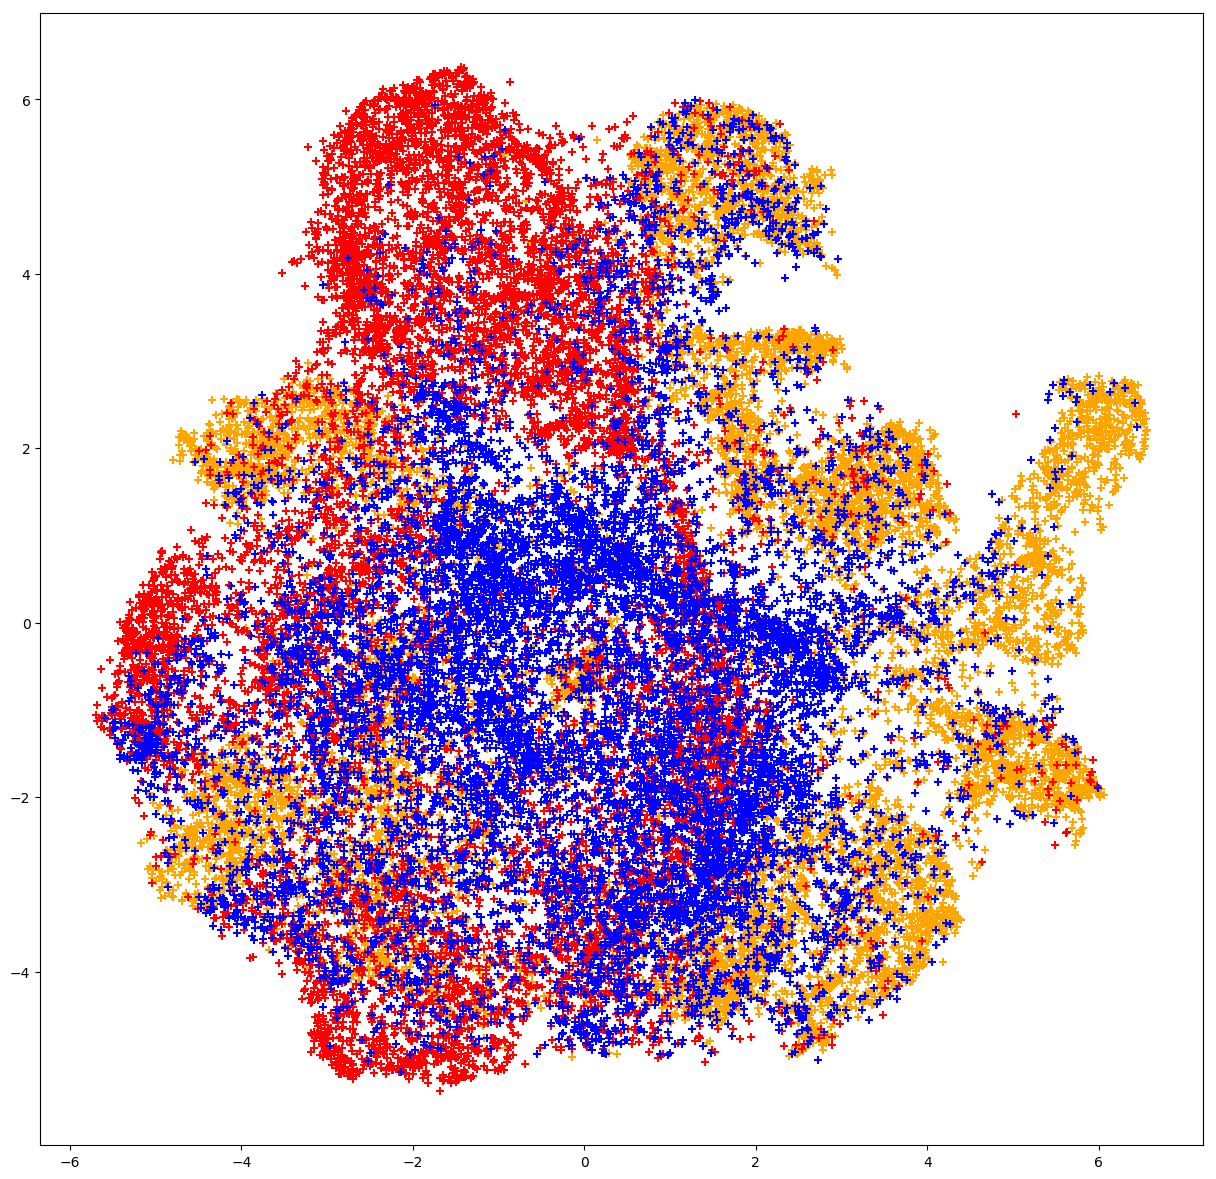

In [22]:
colors = ['orange'] * 10 + ['red', 'blue', 'green', 'lightgreen', 'lightblue', 'lightred']
fig = plt.figure(figsize=(15, 15))
for c in range(len(folders) + 10):
    hf = hfull_2d[yfull==c]
    yf = yfull[yfull==c]
    plt.scatter(hf[:, 0], hf[:, 1], c=colors[c], marker='+')

In [ ]:
output_file('viz.html')
#output_notebook()
div = Div(width=100)

callback = CustomJS(args=dict(div=div), code="""
        var geometry = cb_data['geometry'];
        var width = geometry['x1'] - geometry['x0'];
        var height = geometry['y1'] - geometry['y0'];
        var x = geometry['x0'] + width/2;
        var y = geometry['y0'] + height/2;
        div.text = x.toFixed(2) + "," + (x+width).toFixed(2) + "," + y.toFixed(2) + "," + (y+height).toFixed(2);
    """)
tools = [BoxZoomTool(), WheelZoomTool(), LassoSelectTool(), PanTool(), BoxSelectTool(callback=callback)]
p = figure(plot_width=1000,
           plot_height=1000,
           tools=tools,
           title="Select Below")

hf = hfull_2d
yf = yfull

#hf = hf[yf==10]
#yf = yf[yf==10]

colors = ['orange'] * 10 + ['red', 'blue', 'green', 'lightgreen', 'lightblue', 'lightred']
hcolors = [colors[y] for y in yf]
p.circle(
    hf[:, 0],
    hf[:, 1],
    color=hcolors,
)
layout = column(p, div)
#show(layout)

In [ ]:
x1, x2, y1, y2 = 10.87,13.09,1.21,3.12

mask = (hfull_2d[:, 0] >= x1) * (hfull_2d[:, 0] <= x2) * (hfull_2d[:, 1] >= y1) * (hfull_2d[:, 1] <= y2)
xmask = Xfull[mask]
im = grid_of_images_default(xmask)
imsave('out.png', im)

In [ ]:
n_clusters = 500
clus = KMeans(n_clusters=n_clusters)
clus.fit(hgen)
clusters = clus.predict(hgen)

In [ ]:
indices = np.arange(n_clusters)
intra_distances = []
centers = []
for cl in range(n_clusters):
    h = hgen[clusters==cl]
    center = clus.cluster_centers_[cl]
    centers.append(center)
    h = h.reshape((h.shape[0], -1))
    intra = (np.abs(h - center)).max()
    intra_distances.append(intra)
indices = np.argsort(intra_distances)
centers = np.array(centers)

In [ ]:
imlist = []
for cl in indices:
    x = Xgen[clusters==cl][0:100]
    im = grid_of_images_default(x, shape=(10, 10))
    imlist.append(im)
im = np.array(imlist)
im = grid_of_images_default(im)
imsave('clus.png', im)

In [ ]:
imlist = []
for cl in indices:
    x = Xgen[clusters==cl]
    if len(x)<16:
        continue
    m = KernelDensity(bandwidth=0.01)
    shape = x.shape
    x = x.reshape((x.shape[0], -1))
    m.fit(x)
    yy = m.sample(100)
    yy = yy.reshape((yy.shape[0],) + shape[1:])
    im = grid_of_images_default(yy, shape=(10, 10))
    imlist.append(im)
im = np.array(imlist)
im = grid_of_images_default(im)
imsave('clus.png', im)